In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

import numpy as np

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pickle

# Load data splits from the pickle file
with open('data_splits_128.pkl', 'rb') as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print(f"Data loaded: X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}, y_test shape: {y_test.shape}")



Data loaded: X_train shape: (3500, 128, 128, 3), X_val shape: (1005, 128, 128, 3), X_test shape: (495, 128, 128, 3)
y_train shape: (3500, 128, 128), y_val shape: (1005, 128, 128), y_test shape: (495, 128, 128)


In [3]:
from tensorflow.keras.backend import clear_session
import gc

clear_session()
gc.collect()

0

In [4]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print("Error setting memory growth:", e)


Memory growth enabled for GPUs


In [6]:
print("y_train shape:", y_train.shape)  # Expected: (3500, 256, 256)
print("y_val shape:", y_val.shape)      # Expected: (1005, 256, 256)
print("y_test shape:", y_test.shape)    # Expected: (495, 256, 256)

y_train shape: (3500, 128, 128)
y_val shape: (1005, 128, 128)
y_test shape: (495, 128, 128)


In [7]:
import os
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50


def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name='bn_1')(y_pool)
    y_pool = Activation('relu', name='relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(input_shape, num_classes):
    inputs = Input(input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    x = Conv2D(num_classes, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Load your data
input_shape = (128, 128, 3)
num_classes = len(np.unique(y_train))  # Update this based on your dataset

# Build and compile the model
model = DeepLabV3Plus(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore the best model weights after stopping
)

# Train the model
history = model.fit(
    X_train,
    np.expand_dims(y_train, axis=-1),
    validation_data=(X_val, np.expand_dims(y_val, axis=-1)),
    epochs=10,
    batch_size=2,
    callbacks=[early_stopping]
)

Epoch 1/10
1750/1750 [==============================] - 124s 63ms/step - loss: 0.2065 - accuracy: 0.9225 - val_loss: 0.1703 - val_accuracy: 0.9351
Epoch 2/10
1750/1750 [==============================] - 107s 61ms/step - loss: 0.1573 - accuracy: 0.9394 - val_loss: 0.1588 - val_accuracy: 0.9386
Epoch 3/10
1750/1750 [==============================] - 108s 62ms/step - loss: 0.1470 - accuracy: 0.9429 - val_loss: 0.1482 - val_accuracy: 0.9426
Epoch 4/10
1750/1750 [==============================] - 108s 62ms/step - loss: 0.1405 - accuracy: 0.9451 - val_loss: 0.1451 - val_accuracy: 0.9436
Epoch 5/10
1750/1750 [==============================] - 105s 60ms/step - loss: 0.1365 - accuracy: 0.9464 - val_loss: 0.1408 - val_accuracy: 0.9455
Epoch 6/10
1750/1750 [==============================] - 105s 60ms/step - loss: 0.1328 - accuracy: 0.9477 - val_loss: 0.1376 - val_accuracy: 0.9463
Epoch 7/10
1750/1750 [==============================] - 110s 63ms/step - loss: 0.1305 - accuracy: 0.9484 - val_loss: 0

In [8]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(
    X_test,
    np.expand_dims(y_test, axis=-1),
    batch_size=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


495/495 [==============================] - 7s 14ms/step - loss: 0.1321 - accuracy: 0.9481
Test Loss: 0.13208316266536713
Test Accuracy: 0.9481340646743774


In [9]:
# Make predictions
y_pred = model.predict(X_test, batch_size=1)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Convert one-hot encoding to class indices


495/495 [==============================] - 7s 12ms/step


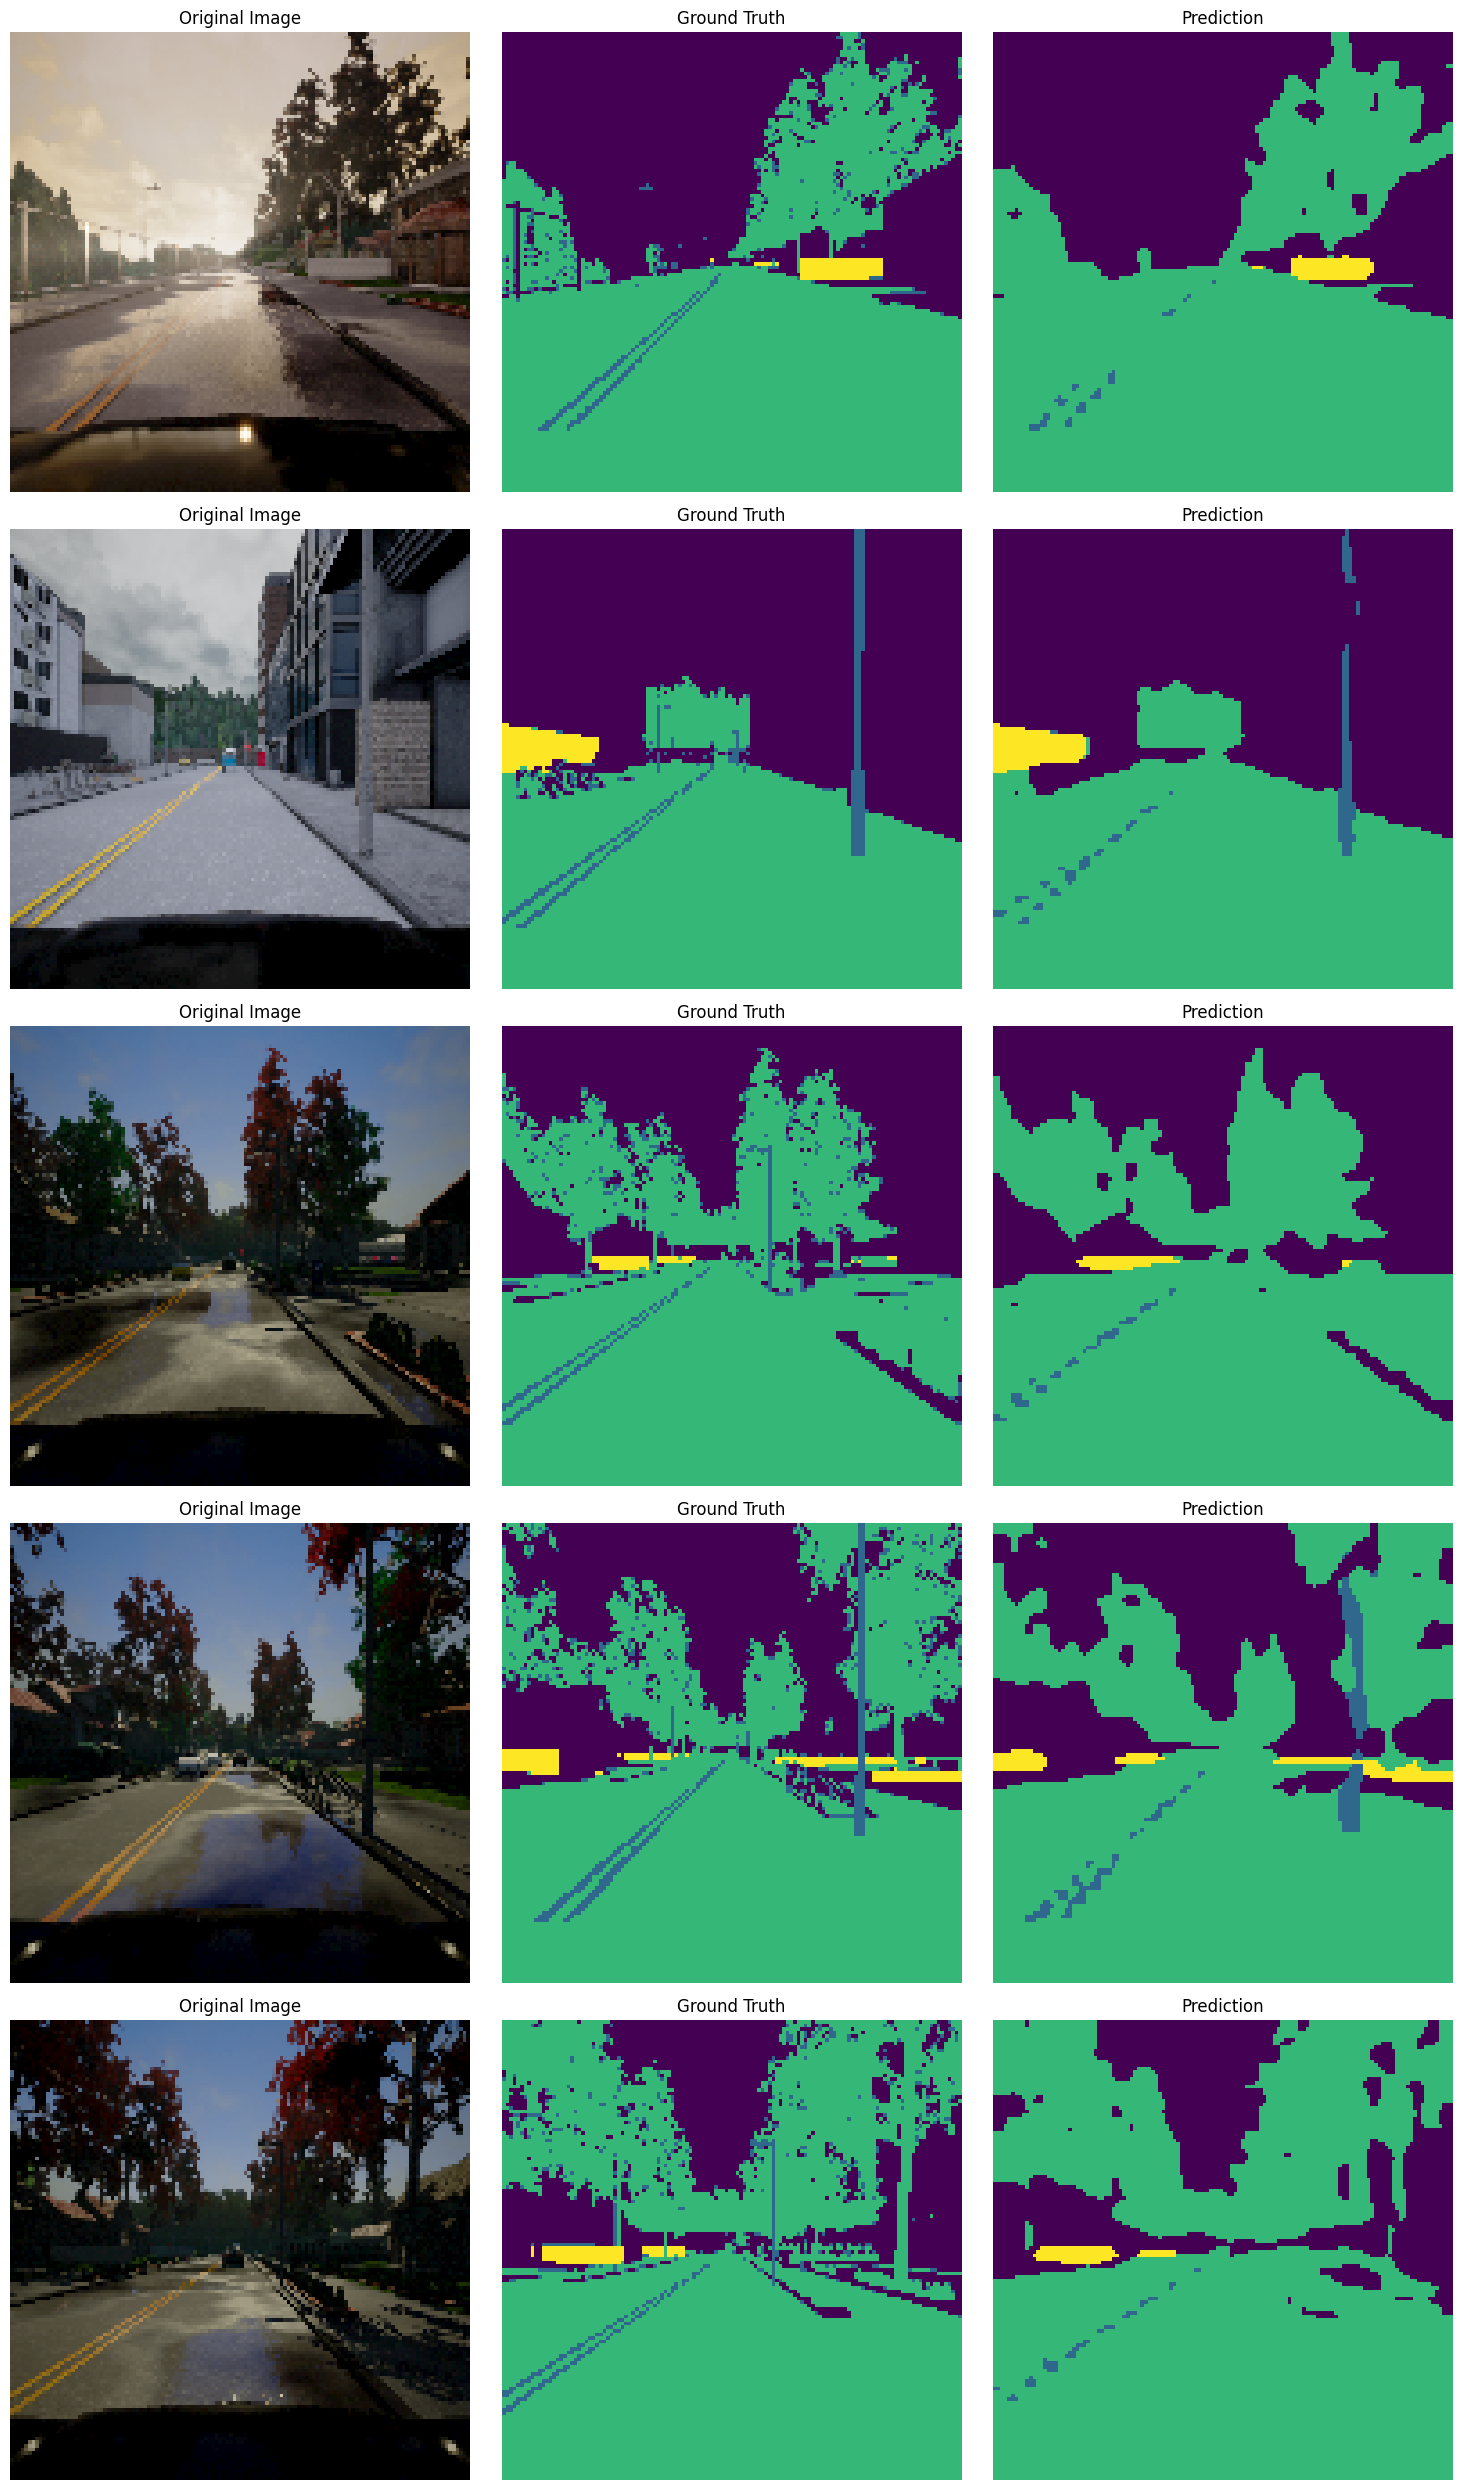

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(X, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[i], cmap="viridis")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[i], cmap="viridis")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the first 5 samples
visualize_predictions(X_test, y_test, y_pred_argmax)


In [11]:
from tensorflow.keras.metrics import MeanIoU

num_classes = len(np.unique(y_test))  # Number of unique classes
iou_metric = MeanIoU(num_classes=num_classes)

# Flatten the arrays for evaluation
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_argmax.flatten()

# Update and calculate IoU
iou_metric.update_state(y_true_flat, y_pred_flat)
mean_iou = iou_metric.result().numpy()

print(f"Mean IoU: {mean_iou}")


Mean IoU: 0.6799238920211792
